In [379]:
# Import required packages
import pandas as pd
import numpy as np
import os
import tarfile
import itertools
import seaborn as sns
import time
import datetime
import matplotlib.pyplot as plt
matplotlib.rcdefaults()

In [77]:
# Read vcf file
vcf_file = pd.read_csv("widiv_2000SNPs_imputed_chr1-10_APGv4_noNA_noHet_q0.2_Q0.8.vcf.gz", skiprows = 30, sep='\t')
vcf_file.head(5)

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,764,...,YANG,YE_4,YE-CHI-HUNG,YELLOW_3-4,YING-55,Yong_28,Yu796_NS,ZS01250,ZS1791,ZS635
0,1,2020872,rs1_2020872,C,G,.,PASS,AC=486;AN=1884,GT,1|1,...,0|0,0|0,0|0,1|1,0|0,0|0,0|0,0|0,1|1,1|1
1,1,2879000,rs1_2879000,A,G,.,PASS,AC=770;AN=1884,GT,0|0,...,1|1,1|1,0|0,0|0,0|0,0|0,0|0,1|1,0|0,0|0
2,1,2896436,rs1_2896436,T,C,.,PASS,AC=902;AN=1884,GT,1|1,...,1|1,1|1,1|1,1|1,1|1,1|1,0|0,1|1,1|1,0|0
3,1,2960695,rs1_2960695,T,A,.,PASS,AC=488;AN=1884,GT,0|0,...,0|0,1|1,0|0,1|1,0|0,0|0,0|0,0|0,0|0,0|0
4,1,3172723,rs1_3172723,C,T,.,PASS,AC=540;AN=1884,GT,0|0,...,0|0,1|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,1|1


In [47]:
#Check if all the varieties are homozygous
vcf_file.columns[vcf_file.isin(["1|0","0|1"]).any()]

Index([], dtype='object')

In [216]:
# Create function for comparing genotypes
def genotype_compare(row):
    (a1, a2) = str(row["CULTIVAR_1_VALUE"]).split("|")
    (b1, b2) = str(row["CULTIVAR_2_VALUE"]).split("|")
    if a1 == b1 and a2 == b2:
        return 1
    elif a1 == b2 and a2 == b1:
        return 1
    elif a1 == b1 or a2 == b2:
        return .5
    else:
        return 0


In [236]:
# Create matrix corresponding to each SNP

def make_matrix(snp, pairwise_genotypes):
    #print(snp)
    snp = pd.DataFrame(snp.iloc[9:])
    snp = snp.reset_index()
    snp.columns.values[1] = "VALUE"
    df = pd.DataFrame(pairwise_genotypes, columns =['CULTIVAR_1', 'CULTIVAR_2'])
    
    df = pd.merge(left = df, right = snp, how='inner', left_on=['CULTIVAR_1'], right_on=["index"])
    df = df.drop("index", axis=1)
    df = df.rename(columns={"VALUE":"CULTIVAR_1_VALUE"})
    
    df = pd.merge(left = df, right = snp, how='inner', left_on=['CULTIVAR_2'], right_on=["index"])
    df = df.drop("index", axis=1)
    df = df.rename(columns={"VALUE":"CULTIVAR_2_VALUE"})
    df["VALUE"] = df.apply(lambda row: genotype_compare(row), axis=1)
    return np.array(df["VALUE"])

In [50]:
# Read pheno data
pheno_data = pd.read_csv("widiv2021pheno_4colorclasses_cleaned02272023.csv")
pheno_data.head(5)

,Unnamed: 0,common_name,GRIN,EarHeightP2,EarLeafNumberP1,EarLeafNumberP2,ExpLeaves1P1,ExpLeaves1P2,ExpLeaves2P1,ExpLeaves2P2,...,LargestLeafNumberP1,LargestLeafNumberP2,LargestLeafWidthP2,StandCount2,AntherColor,SilkColor,#_of_ears,Weight_(g),Moisture_(%),TestWeight_(lb/bu)
0,0,11430,PI601558,56.0,13.0,12.5,5.0,4.5,7.5,7.0,...,12.5,13.0,8.70,41.0,3.0,3.0,6.0,589.10,10.95,57.90
1,1,1538,PI601658,43.5,11.0,11.0,5.5,5.0,8.5,8.0,...,11.5,11.5,7.05,43.5,2.0,1.0,6.0,349.60,10.30,59.80
2,2,2369,PI601559,75.5,13.0,13.5,4.5,5.0,7.0,7.0,...,11.5,11.5,9.15,40.0,2.0,3.0,6.0,718.40,12.90,60.90
3,3,33-16,Ames26771,67.0,11.5,12.5,3.5,3.0,5.5,5.5,...,11.5,12.5,8.10,32.5,2.0,1.0,6.0,559.35,12.70,55.45
4,4,38-11,Ames26604,89.0,14.5,14.5,4.5,5.0,7.5,8.0,...,14.5,14.0,7.75,21.0,2.0,1.0,6.5,644.75,10.90,58.55


In [52]:
# Find common list (sorted) of genotypes
genotype_list = sorted(list(set(pheno_data["common_name"].unique()) & set(vcf_file.columns[9:])))
print("Number of genotypes considered:" + str(len(genotype_list)))

Number of genotypes considered:757


In [59]:
# Create combinations of genotypes
pairwise_genotypes = list(itertools.combinations(genotype_list, 2))
print("Number of genotype combinations:" + str(len(pairwise_genotypes)))

Number of genotype combinations:286146


In [60]:
# Create the "target" correlation matrix
def func(phenotype_file_df, genotype_column_header,phenotype):
    cultivar_estimated_corr_df = pd.DataFrame(pairwise_genotypes, columns =['CULTIVAR_1', 'CULTIVAR_2'])
    cultivar_estimated_corr_df = pd.merge(left = cultivar_estimated_corr_df, 
                                          right = phenotype_file_df, how='inner', 
                                          left_on=['CULTIVAR_1'], right_on=[genotype_column_header])
    cultivar_estimated_corr_df = cultivar_estimated_corr_df.rename(columns={phenotype:phenotype+"_1"})
    
    cultivar_estimated_corr_df = pd.merge(left = cultivar_estimated_corr_df, 
                                          right = phenotype_file_df, how='inner', 
                                          left_on=['CULTIVAR_2'], right_on=[genotype_column_header])
    cultivar_estimated_corr_df = cultivar_estimated_corr_df.rename(columns={phenotype:phenotype+"_2"})
    
    cultivar_estimated_corr_df["difference"] = abs(cultivar_estimated_corr_df[phenotype+"_1"] - cultivar_estimated_corr_df[phenotype+"_2"])
    cultivar_estimated_corr_df = cultivar_estimated_corr_df[["CULTIVAR_1", "CULTIVAR_2", "difference"]]
    max_diff = cultivar_estimated_corr_df["difference"].max()
    min_diff = cultivar_estimated_corr_df["difference"].min()
    cultivar_estimated_corr_df["estimated_corr"] = round((cultivar_estimated_corr_df["difference"]-min_diff)/(max_diff - min_diff),2)
    cultivar_estimated_corr_df["estimated_corr"] = 1 - cultivar_estimated_corr_df["estimated_corr"]
    return cultivar_estimated_corr_df

In [61]:
# Create estimated correlations corresponding to each combinations of cultivars
pheno_corr_df = func(pheno_data,"common_name","MaizeObsTarSpot")
pheno_corr_df

,CULTIVAR_1,CULTIVAR_2,difference,estimated_corr
0,11430,1538,3.725,0.68
1,11430,2369,4.075,0.65
2,1538,2369,0.350,0.97
3,11430,33-16,2.625,0.78
4,1538,33-16,1.100,0.91
...,...,...,...,...
286141,YING-55,ZS635,1.375,0.88
286142,Yong_28,ZS635,0.775,0.93
286143,Yu796_NS,ZS635,1.125,0.90
286144,ZS01250,ZS635,1.125,0.90


<AxesSubplot:xlabel='estimated_corr', ylabel='Count'>

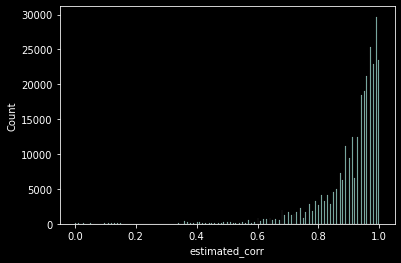

In [65]:
sns.histplot(pheno_corr_df["difference"])

In [238]:
# Create snp matrix
vcf_file["matrix"] = vcf_file.apply(lambda row: (make_matrix(row, pairwise_genotypes)), axis =1)

In [241]:
# Dump the file for later use
vcf_file.to_pickle("./snp_matrix.pkl")

In [243]:
# Read the vcf file from dump
vcf_file = pd.read_pickle("./snp_matrix.pkl")

In [251]:
from scipy.stats import pearsonr, pointbiserialr
def point_biserial_correlation(X,Y):
    return pointbiserialr(X,Y)[0];
    

In [262]:
def calculate_corr_coeff(target_corr, snp_matrices, corr="BISERIAL"):
    result = []
    for i in range(0, snp_matrices.shape[0]):
        result.append(point_biserial_correlation(target_corr,  snp_matrices[i]))
    return np.array(result)

In [344]:
# Extraction of significan SNPs
snp_matrices_index_list = list(vcf_file["ID"])
snp_matrices = np.array(vcf_file["matrix"])
cultivar_estimated_corr = np.array(pheno_corr_df["estimated_corr"])
start_time = time.time()
snp_list = []
snp_list_ind = []
corr_coeff = []
corr_coeff_temp = calculate_corr_coeff(cultivar_estimated_corr, snp_matrices)
snp_list.append(snp_matrices_index_list[np.argmax(corr_coeff_temp)])
snp_list_ind.append(np.argmax(corr_coeff_temp))
corr_coeff.append(np.max(corr_coeff_temp))

#del snp_matrices
#del corr_coeff_temp
num_iterations = 500 #len(snp_matrices_index_list)
    
while len(snp_list) < num_iterations:
        snp_matrices_processed = np.array([(snp_matrices.tolist())[i] for i in snp_list_ind])
        snp_matrices_processed = snp_matrices_processed.sum(axis=0)
        
        snp_matrices_left_ind = list(set(np.arange(0,len(snp_matrices_index_list))) - set(snp_list_ind))
        snp_matrices_left = np.array([(snp_matrices.tolist())[i] for i in snp_matrices_left_ind])
        
        snp_matrices_left = snp_matrices_left + snp_matrices_processed
        corr = calculate_corr_coeff(cultivar_estimated_corr, snp_matrices_left)
        snp_list.append(snp_matrices_index_list[snp_matrices_left_ind[np.argmax(corr)]])
        snp_list_ind.append(snp_matrices_left_ind[np.argmax(corr)])
        corr_coeff.append(np.max(corr))
elapsed = time.time() - start_time
elapsed = str(datetime.timedelta(seconds=elapsed))
                
print("Execution Time:"+elapsed)
print("Highest Correlation Achieved:" + str(round(max(corr_coeff),2)))
snp_df = pd.DataFrame(snp_list) 
snp_df.to_csv("ordered_SNP_list.csv", index=False, header=['SNP_ID']) 
max_ind = np.argmax(corr_coeff)
filtered_snp_df = pd.DataFrame(snp_list[0:max_ind])
filtered_snp_df.to_csv("effective_SNP_list.csv", index=False, header=['SNP_ID']) 
print("Number of Effective SNPs:" + str(len(snp_list[0:max_ind])))
    

Execution Time:1:52:15.554103
Highest Correlation Achieved:0.33
Number of Effective SNPs:124


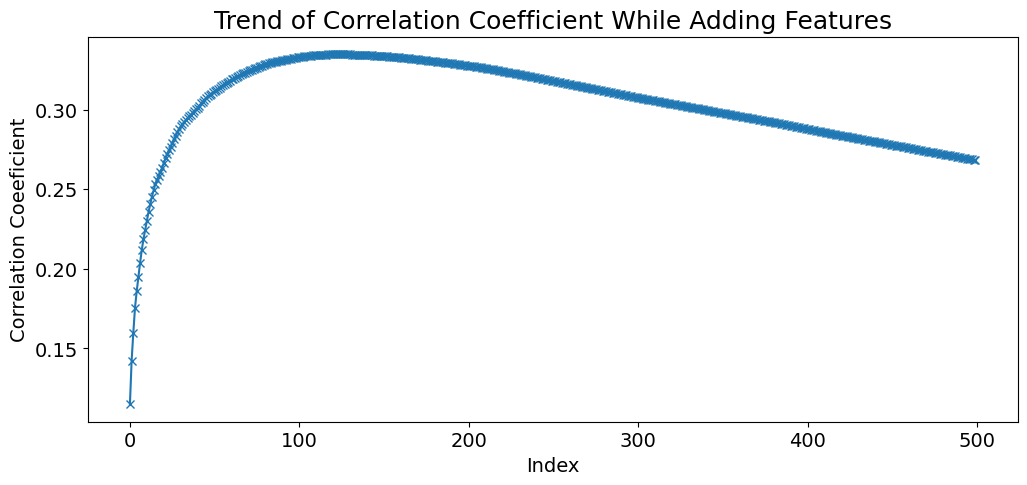

In [383]:
plt.figure(figsize=(12,5))
plt.plot(corr_coeff, marker='x')
plt.title("Trend of Correlation Coefficient While Adding Features", fontsize=18)
plt.xlabel("Index", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.ylabel("Correlation Coeeficient", fontsize=14)
plt.savefig("correlation_trend.png")

In [374]:
# Read KAML output for SNP estimates
temp = pd.read_csv("KAML_Debasmita_reduced_2000SNPs/cv.p.csv")
KAML_output = pd.DataFrame(pd.Series(vcf_file["ID"]))
KAML_output = pd.concat([KAML_output, temp], axis=1)
KAML_output

,ID,Unnamed: 0,V1,V2,V3,V4
0,rs1_2020872,1,0.367660,0.191434,0.006641,0.049900
1,rs1_2879000,2,0.364928,0.632442,0.389246,0.799637
2,rs1_2896436,3,0.737206,0.559232,0.541710,0.942179
3,rs1_2960695,4,0.528025,0.372043,0.558716,0.569553
4,rs1_3172723,5,0.400551,0.728746,0.481272,0.984512
...,...,...,...,...,...,...
1995,rs10_148124641,1996,0.013386,0.258755,0.256924,0.058304
1996,rs10_148909540,1997,0.758429,0.605834,0.247074,0.867423
1997,rs10_148914063,1998,0.309475,0.976098,0.935318,0.631198
1998,rs10_148917829,1999,0.123915,0.914427,0.110070,0.166076


In [375]:
KAML_output_eff_snps = pd.merge(left = KAML_output, right = filtered_snp_df, how='inner', left_on=['ID'], right_on=[0])
KAML_output_eff_snps

,ID,Unnamed: 0,V1,V2,V3,V4,0
0,rs1_2960695,4,0.528025,0.372043,0.558716,0.569553,rs1_2960695
1,rs1_16707547,28,0.565101,0.111556,0.080294,0.205215,rs1_16707547
2,rs1_20833972,38,0.768483,0.632871,0.449924,0.541565,rs1_20833972
3,rs1_41836431,67,0.218340,0.676298,0.700867,0.333503,rs1_41836431
4,rs1_53292868,89,0.009095,0.383296,0.019002,0.019783,rs1_53292868
...,...,...,...,...,...,...,...
119,rs9_144620737,1831,0.256503,0.139306,0.752678,0.218222,rs9_144620737
120,rs10_8659558,1878,0.230504,0.022608,0.033612,0.044793,rs10_8659558
121,rs10_32090377,1898,0.014971,0.195704,0.509518,0.069073,rs10_32090377
122,rs10_65532872,1904,0.458483,0.651533,0.554532,0.730885,rs10_65532872


Text(0, 0.5, 'Count of SNPs by P2G Approach')

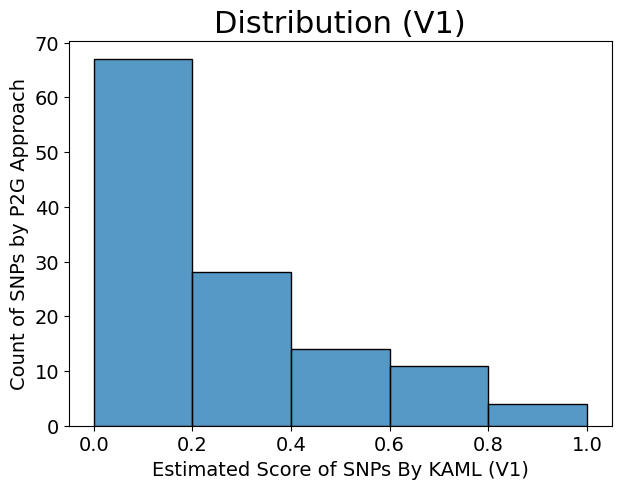

In [404]:
plt.figure(figsize=(7,5))
fig = sns.histplot(KAML_output_eff_snps["V1"], binwidth=0.2)
plt.title("Distribution (V1)", fontsize=22)
plt.xlabel("Estimated Score of SNPs By KAML (V1)", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.ylabel("Count of SNPs by P2G Approach", fontsize=14)

Text(0, 0.5, 'Count of SNPs by P2G Approach')

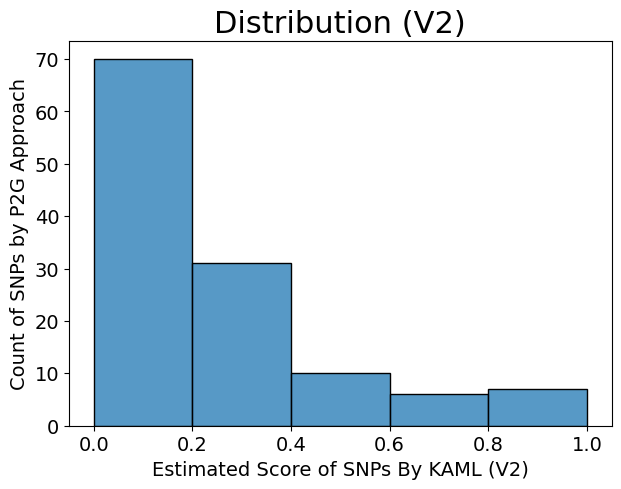

In [406]:
plt.figure(figsize=(7,5))
fig = sns.histplot(KAML_output_eff_snps["V2"], binwidth=0.2)
plt.title("Distribution (V2)", fontsize=22)
plt.xlabel("Estimated Score of SNPs By KAML (V2)", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.ylabel("Count of SNPs by P2G Approach", fontsize=14)

Text(0, 0.5, 'Count of SNPs by P2G Approach')

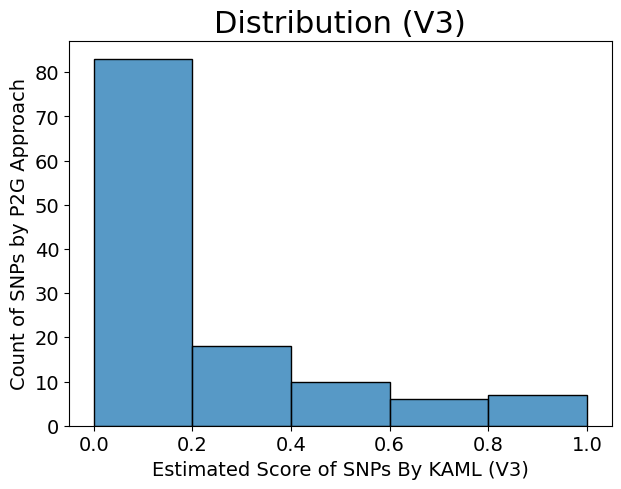

In [407]:
plt.figure(figsize=(7,5))
fig = sns.histplot(KAML_output_eff_snps["V3"], binwidth=0.2)
plt.title("Distribution (V3)", fontsize=22)
plt.xlabel("Estimated Score of SNPs By KAML (V3)", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.ylabel("Count of SNPs by P2G Approach", fontsize=14)

Text(0, 0.5, 'Count of SNPs by P2G Approach')

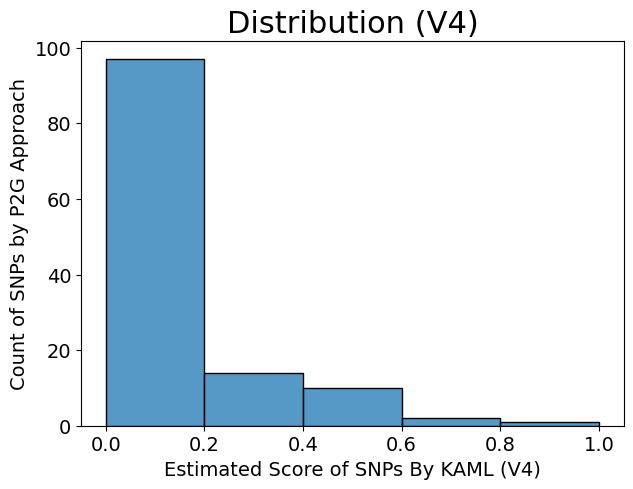

In [408]:
plt.figure(figsize=(7,5))
fig = sns.histplot(KAML_output_eff_snps["V4"], binwidth=0.2)
plt.title("Distribution (V4)", fontsize=22)
plt.xlabel("Estimated Score of SNPs By KAML (V4)", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.ylabel("Count of SNPs by P2G Approach", fontsize=14)

Text(0, 0.5, 'Count of SNPs')

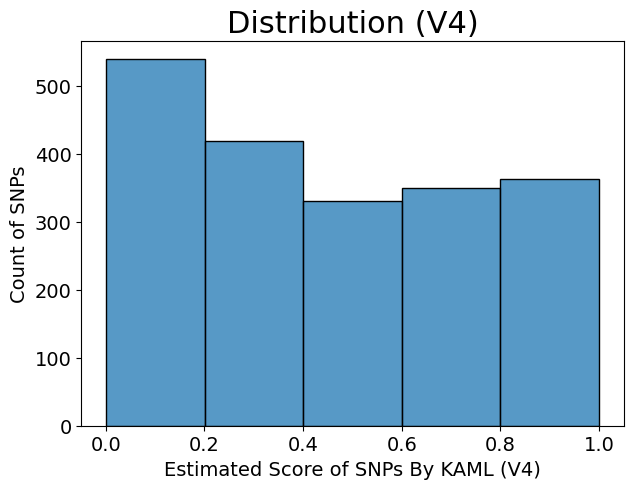

In [440]:
plt.figure(figsize=(7,5))
fig = sns.histplot(KAML_output["V4"], binwidth=0.2)
plt.title("Distribution (V4)", fontsize=22)
plt.xlabel("Estimated Score of SNPs By KAML (V4)", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.ylabel("Count of SNPs", fontsize=14)

<ipython-input-424-3e93330012c4>:4: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


([], [])

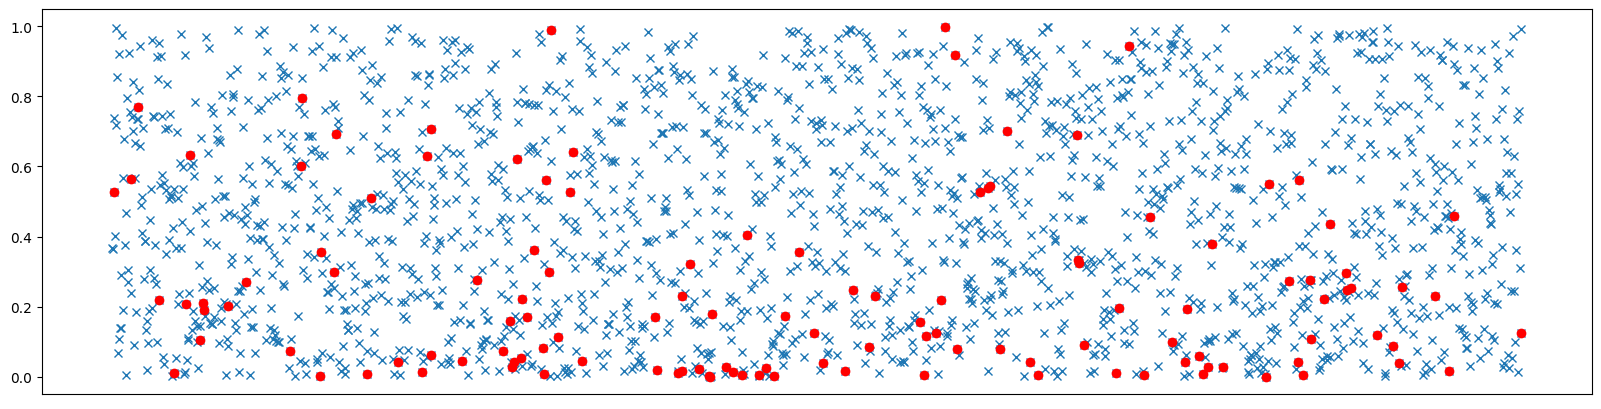

In [424]:
plt.figure(figsize=(20,5))
plt.plot(KAML_output["ID"], KAML_output["V1"], marker='x', linestyle='None')
plt.plot(KAML_output_eff_snps["ID"], KAML_output_eff_snps["V1"], marker='o', linestyle='None', color='r')
plt.xticks([])

<ipython-input-425-c48423d3b5fd>:4: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


([], [])

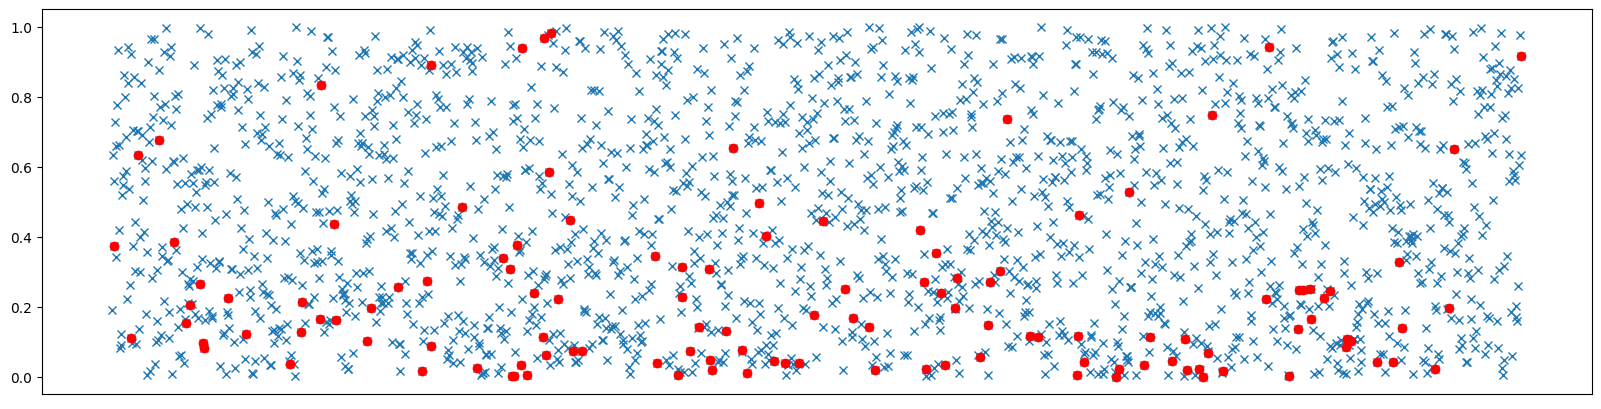

In [425]:
plt.figure(figsize=(20,5))
plt.plot(KAML_output["ID"], KAML_output["V2"], marker='x', linestyle='None')
plt.plot(KAML_output_eff_snps["ID"], KAML_output_eff_snps["V2"], marker='o', linestyle='None', color='r')
plt.xticks([])

<ipython-input-426-f448e1d2298d>:4: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


([], [])

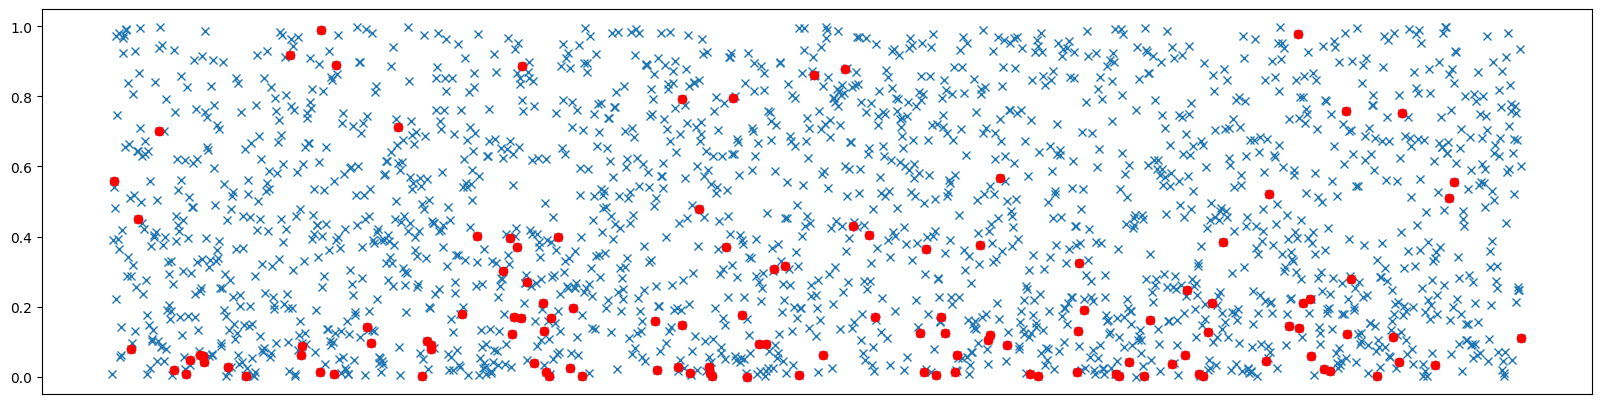

In [426]:
plt.figure(figsize=(20,5))
plt.plot(KAML_output["ID"], KAML_output["V3"], marker='x', linestyle='None')
plt.plot(KAML_output_eff_snps["ID"], KAML_output_eff_snps["V3"], marker='o', linestyle='None', color='r')
plt.xticks([])

<ipython-input-427-e7b3c5e18afd>:4: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


([], [])

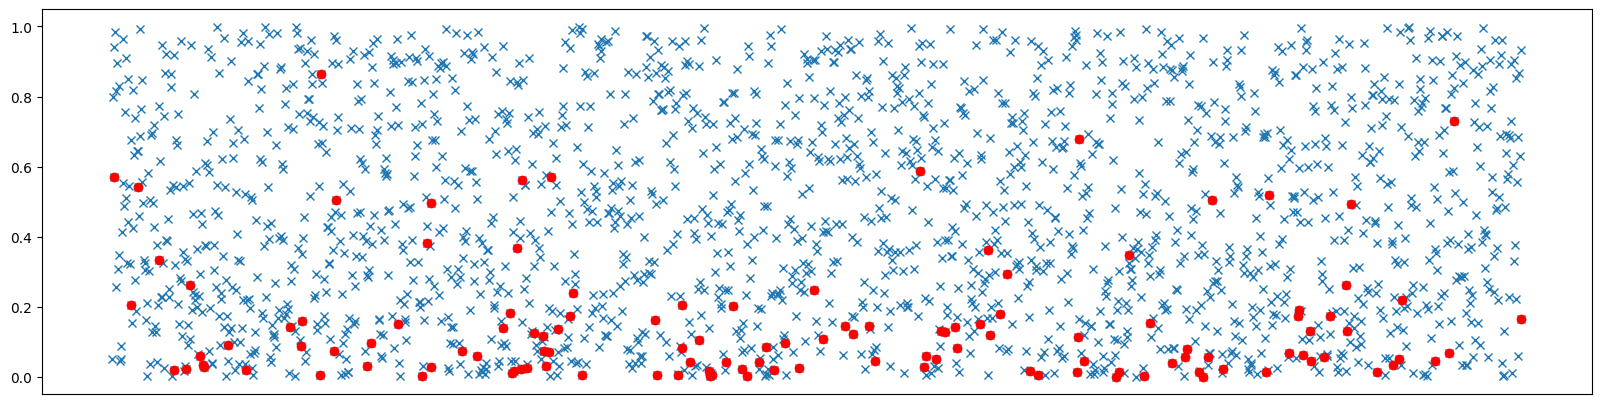

In [427]:
plt.figure(figsize=(20,5))
plt.plot(KAML_output["ID"], KAML_output["V4"], marker='x', linestyle='None')
plt.plot(KAML_output_eff_snps["ID"], KAML_output_eff_snps["V4"], marker='o', linestyle='None', color='r')
plt.xticks([])

In [428]:
pheno_data

,Unnamed: 0,common_name,GRIN,EarHeightP2,EarLeafNumberP1,EarLeafNumberP2,ExpLeaves1P1,ExpLeaves1P2,ExpLeaves2P1,ExpLeaves2P2,...,LargestLeafNumberP1,LargestLeafNumberP2,LargestLeafWidthP2,StandCount2,AntherColor,SilkColor,#_of_ears,Weight_(g),Moisture_(%),TestWeight_(lb/bu)
0,0,11430,PI601558,56.0,13.0,12.5,5.0,4.5,7.5,7.0,...,12.5,13.0,8.70,41.0,3.0,3.0,6.0,589.10,10.95,57.90
1,1,1538,PI601658,43.5,11.0,11.0,5.5,5.0,8.5,8.0,...,11.5,11.5,7.05,43.5,2.0,1.0,6.0,349.60,10.30,59.80
2,2,2369,PI601559,75.5,13.0,13.5,4.5,5.0,7.0,7.0,...,11.5,11.5,9.15,40.0,2.0,3.0,6.0,718.40,12.90,60.90
3,3,33-16,Ames26771,67.0,11.5,12.5,3.5,3.0,5.5,5.5,...,11.5,12.5,8.10,32.5,2.0,1.0,6.0,559.35,12.70,55.45
4,4,38-11,Ames26604,89.0,14.5,14.5,4.5,5.0,7.5,8.0,...,14.5,14.0,7.75,21.0,2.0,1.0,6.5,644.75,10.90,58.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,756,Yong_28,Ames2333,72.5,14.5,14.5,5.0,5.0,8.5,7.5,...,15.0,13.0,8.20,24.5,2.0,3.0,7.0,681.95,11.65,57.60
757,757,Yu796_NS,Ames27196,26.0,10.5,9.5,3.5,4.0,6.5,6.5,...,12.0,10.5,7.70,29.5,3.0,3.0,7.0,452.90,10.50,60.60
758,758,ZS01250,PI595616,50.5,12.0,12.0,4.5,4.5,7.5,7.5,...,11.0,11.0,6.35,23.0,2.0,2.0,7.5,405.55,11.60,53.00
759,759,ZS1791,PI591619,49.0,11.5,12.5,4.0,4.0,6.0,7.0,...,11.5,11.5,8.35,33.5,2.0,3.0,6.0,711.70,10.80,59.30


In [434]:
trait_data = pd.read_csv("combined_traits_tar_pruned.csv", sep='\t')
predicted_pheno_2000 = pd.read_csv("KAML_Debasmita_reduced_2000SNPs/KAML.MaizeObsTarSpot.pred.txt")
predicted_pheno_124 = pd.read_csv("KAML_Debasmita_reduced_124SNPs/KAML.MaizeObsTarSpot.pred.txt")
predicted_pheno_124

,MaizeObsTarSpot
0,0.720125
1,0.720125
2,0.720125
3,0.720125
4,0.720125
...,...
752,1.023109
753,0.980539
754,0.720125
755,0.720125


In [435]:
def RMSE(y_actual, y_pred):
    MSE = np.square(np.subtract(y_actual,y_pred)).mean() 
    RMSE = np.sqrt(MSE)
    return RMSE

In [438]:
pearsonr(trait_data["MaizeObsTarSpot"], predicted_pheno_2000["MaizeObsTarSpot"])

(0.7714640177467591, 2.1180260193076318e-150)

In [439]:
pearsonr(trait_data["MaizeObsTarSpot"], predicted_pheno_124["MaizeObsTarSpot"])

(0.1809933000488697, 5.358434722445253e-07)